<a href="https://colab.research.google.com/github/adasinghasd123/Machine_Learning/blob/main/VAE_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the required package
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy

#importing the dataset from keras
from keras.datasets import mnist


np.random.seed(25)
tf.executing_eagerly()

False

In [2]:
#toring the dataset in X_train and X_test

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


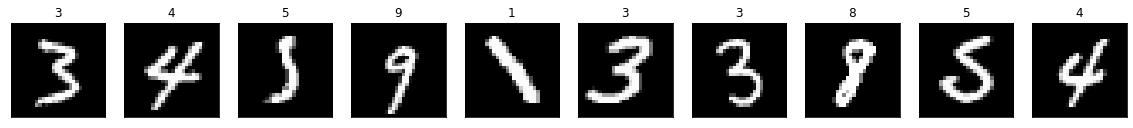

In [3]:
#show images at index 130 to 139 taken from X_train array
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(130, 140):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [4]:
X_train.shape


(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

In [6]:
X_test.shape

(10000, 28, 28)

In [7]:
y_test.shape

(10000,)

In [8]:
#normalize the pixel in range of 0 to 1 instead of 0 to 255
X_train = X_train/255
X_test = X_test/255   

In [9]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [10]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [11]:
print(X_train_new.shape)
print(X_test_new.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


**Now we are going to construct VAE architecture**

In [12]:
#Constructing encoder

#defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

1.using Sequential API
Here we create the model layer-by-layer. It is very simple and easy to use. But sharing of layers or branching of layers is not allowed (We will see what sharing or branching means later). Also, you can’t have multiple inputs or outputs.

---
   2.using Functional API
It is more flexible than the sequential API. It is more powerful than the sequential API in the sense branching or sharing of layers is allowed here. And also it can have multiple inputs and outputs.


In [13]:
#we are using Functioanl approach


#input layer
encoder_input = Input(shape=input_shape)

# 2 convolution layers
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

# Flatten layer to reshape all data into a single one-dimensional array
encoder = Flatten()(encoder_conv)

# now connected to mu and sigma layer, each  having 2 neurons
mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [14]:
#Now we need to  define a function called compute_latent() which is going to be used to determine the values in the latent space layer.

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

In [15]:
#Lambda layer
#reparameterization trick

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

In [16]:
#shape of convolution layer in conv_shape
conv_shape = K.int_shape(encoder_conv)
print(conv_shape)

(None, 14, 14, 16)


In [17]:
#Constructing decoder

decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

#Conv2DTranspose for inverse transformation of the standard Conv2D layer
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [18]:
#Connecting the encoder and decoder

encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

In [21]:
#still, the encoder and decoder part are not connected just yet. So we need to link the two in order to construct the entire VAE
#output of vae model is the output of decoder in which its input is taken from the output of encoder
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [22]:
# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [23]:
# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [ ]:
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=10, batch_size=32, validation_data=(X_test_new,X_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 181.2097

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 49s 820us/sample - loss: 181.2097 - val_loss: 169.8791
Epoch 2/10
60000/60000 [==============================] - 43s 711us/sample - loss: 168.2523 - val_loss: 167.1095
Epoch 3/10
60000/60000 [==============================] - 47s 789us/sample - loss: 166.3878 - val_loss: 165.4754
Epoch 4/10
60000/60000 [==============================] - 40s 670us/sample - loss: 165.2976 - val_loss: 164.7062
Epoch 5/10
 2752/60000 [>.............................] - ETA: 36s - loss: 163.7202

In [ ]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)


In [ ]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

In [ ]:
# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

In [ ]:
# Displaying several new images
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-2,1,0,2,9)

# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)